<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Data-splitting" data-toc-modified-id="Data-splitting-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Data splitting</a></span></li><li><span><a href="#Converting-the-dataset-to-an-implicit-feedback-dataset" data-toc-modified-id="Converting-the-dataset-to-an-implicit-feedback-dataset-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Converting the dataset to an implicit feedback dataset</a></span></li></ul></li><li><span><a href="#Build-Neural-Collaborative-Filtering-(NCF)" data-toc-modified-id="Build-Neural-Collaborative-Filtering-(NCF)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Build Neural Collaborative Filtering (NCF)</a></span><ul class="toc-item"><li><span><a href="#Evaluating-our-Recommender-System" data-toc-modified-id="Evaluating-our-Recommender-System-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Evaluating our Recommender System</a></span></li></ul></li><li><span><a href="#Your-work" data-toc-modified-id="Your-work-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Your work</a></span><ul class="toc-item"><li><span><a href="#Step-1-:-Try-to-find-best-hyper-parameters-for-Hit-Ratio-at-10" data-toc-modified-id="Step-1-:-Try-to-find-best-hyper-parameters-for-Hit-Ratio-at-10-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Step 1 : Try to find best hyper-parameters for Hit Ratio at 10</a></span></li><li><span><a href="#Step-2-:-Add-new-features-in-order-to-improve-the-Hit-Ratio-at-10" data-toc-modified-id="Step-2-:-Add-new-features-in-order-to-improve-the-Hit-Ratio-at-10-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Step 2 : Add new features in order to improve the Hit Ratio at 10</a></span></li><li><span><a href="#Step-3---Improve-the-network-by-using-a-General-Matrix-Factorisation-layer" data-toc-modified-id="Step-3---Improve-the-network-by-using-a-General-Matrix-Factorisation-layer-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Step 3 - Improve the network by using a General Matrix Factorisation layer</a></span></li><li><span><a href="#Step-4---Final-architecture" data-toc-modified-id="Step-4---Final-architecture-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Step 4 - Final architecture</a></span></li></ul></li></ul></div>

# Building a deep recommender systems

**Main part**

* The difference between implicit and explicit feedback for recommender systems
* How to train-test split a dataset for training recommender systems without introducing biases and data leakages
* How to create your own deep learning based recommender system using Keras
* Metrics for evaluating recommender systems (hint: accuracy or RMSE is not appropriate!)

For the first part, we use here the MovieLens 100K Dataset. It contain 100,000 ratings from 1000 users on 1700 movies.

* u.train / u.test part of the original u.data information
    * The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   
* u.info
    * The number of users, items, and ratings in the u data set.
* u.item
    * Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.
* u.genre
    * A list of the genres.
* u.user
    * Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

In [4]:
#path = "https://www.i3s.unice.fr/~riveill/dataset/dataset_movilens_100K/"
try:
    import wget
except:
    !pip install wget
    import wget
wget.download('https://files.grouplens.org/datasets/movielens/ml-100k.zip')


  Using cached wget-3.2-py3-none-any.whl

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


'ml-100k (1).zip'

In [5]:
import zipfile

with zipfile.ZipFile('./ml-100k.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Before we build our model, it is important to understand the distinction between implicit and explicit feedback, and why modern recommender systems are built on implicit feedback.

* **Explicit Feedback:** in the context of recommender systems, explicit feedback are direct and quantitative data collected from users.
* **Implicit Feedback:** on the other hand, implicit feedback are collected indirectly from user interactions, and they act as a proxy for user preference. 

The advantage of implicit feedback is that it is abundant. Recommender systems built using implicit feedback allow recommendations to be adapted in real time, with each click and interaction.

Today, online recommender systems are built using implicit feedback.

### Data preprocessing

For fast training and testing your code, you can keep the first entries of the dataset only by tuning n_keep

In [53]:
# Load data
import pandas as pd
import numpy as np

np.random.seed(123)

n_keep = 10000

path = './ml-100k/'
ratings = pd.read_csv(path + 'u.data', sep='\t', header=None,
                      names=['userId', 'movieId', 'rating', 'timestamp']).iloc[:n_keep, :]
ratings = ratings.sort_values(['timestamp'], ascending=True)
ratings.head()

,userId,movieId,rating,timestamp
214,259,255,4,874724710
1766,259,772,4,874724882
159,259,117,4,874724988
4029,259,405,3,874725120
4334,259,176,4,874725386


### Data splitting

Separating the dataset between train and test in a random fashion would not be fair, as we could potentially use a user's recent evaluations for training and previous evaluations. This introduces a data leakage with an anticipation bias, and the performance of the trained model would not be generalizable to real world performance.

Therefore, we need to slice the train and test based on the timestamp


In [54]:
# Split dataset
train_ratings, test_ratings = np.split(ratings, [int(.67 * len(ratings))])

max(train_ratings['timestamp']) <= min(test_ratings['timestamp'])

True

In [55]:
# drop columns that we no longer need
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

len(train_ratings), len(test_ratings)

(6700, 3300)

### Converting the dataset to an implicit feedback dataset

As discussed earlier, we will train a recommender system using implicit feedback. However, the MovieLens dataset we use is based on explicit feedback. To convert this dataset to an implicit feedback dataset, we will simply binarize the ratings and convert them to '1' (i.e. a positive class). The value '1' means that the user has interacted with the element.

It is important to note that using implicit feedback reframes the problem our recommender is trying to solve. Instead of trying to predict the ranking of movies using explicit feedback, we try to predict whether the user will interact (i.e., click/buy/watch) with each movie, with the goal of presenting users with the movies with the highest probability of interaction.

In [56]:
train_ratings['interaction'] = 1
train_ratings.head()

,userId,movieId,rating,interaction
214,259,255,4,1
1766,259,772,4,1
159,259,117,4,1
4029,259,405,3,1
4334,259,176,4,1


However, we now have a problem. After binarizing our data set, we find that every sample in the data set now belongs to the positive class. However, we also need negative samples to train our models, to indicate the movies that the user did not interact with. We assume that these movies are the ones the user is not interested in - although this is a general assumption that may not be true, it works quite well in practice.

The code below generates 4 negative samples for each row of data. In other words, the ratio of negative to positive samples is 4:1. This ratio is chosen arbitrarily but it works quite well in practice.

**[TO DO - Students]: Fill the gaps**

In [57]:
# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()
print('movies statistics: ', len(all_movieIds))
# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in user_item_set:
    users.append(u)
    items.append(i)
    labels.append(1)  # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds)
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0)  # items not interacted with are negative

movies statistics:  1254


## Build Neural Collaborative Filtering (NCF)

As there are many deep learning based architectures for recommender systems, I propose here to use the framework proposed by [He et al, Neural Collaborative Filtering](https://arxiv.org/abs/1708.05031) which is simple enough to be implemented in an introductory context.

In a "collaborative" approach, the user and the embedded elements are essential to the model. Here is a description of the architecture: ![architecture](https://miro.medium.com/max/4800/1*lYD7OP53iK_y4lt6XWjubQ.png)

The inputs to the model are the one-hot encoded user and item vector for userId = 3 and movieId = 1. Because this is a positive sample (movie actually rated by the user), the true label (interacted) is 1.
The user input vector and item input vector are fed to the user embedding and item embedding respectively, which results in a smaller, denser user and item vectors.

The embedded user and item vectors are concatenated before passing through a series of fully connected layers, which maps the concatenated embeddings into a prediction vector as output. At the output layer, we apply a Sigmoid function to obtain the most probable class. In the example above, the most probable class is 1 (positive class), since 0.8 > 0.2.

This [tutorial](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/) shows you how to make an embedding with Keras 

**[TO DO - Students]: Fill the gaps**

In [58]:
from tensorflow.keras.models import Model
from keras.layers import Dense, Embedding, Concatenate, Input, Flatten


def NCF(num_users, num_items):
    # user_id embedding
    users_input = Input(shape=(1,))
    x_users = Embedding(input_dim=num_users, output_dim=8)(users_input)
    x_users = Flatten()(x_users)

    # item_id embedding
    items_input = Input(shape=(1,))
    x_items = Embedding(input_dim=num_items, output_dim=8)(items_input)
    x_items = Flatten()(x_items)

    # concatenation
    x = Concatenate(axis=1)([x_users, x_items])

    # output layer
    output = Dense(1, activation='sigmoid')(x)

    # Build the model
    model = Model(inputs=[users_input, items_input], outputs=output)

    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # summarize the model
    print(model.summary())

    return model

In [59]:
num_users = max(np.unique(users)) + 1
num_items = max(np.unique(items)) + 1

In [60]:
model = NCF(num_users, num_items)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 8)         3120        ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 8)         12240       ['input_4[0][0]']                
                                                                                            

In [61]:
# Model fitting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# simple early stopping
es = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True, verbose=1)
mc = ModelCheckpoint("best-model", monitor="val_loss", save_best_only=True, save_weights_only=True)

#model.fit([np.array(users), np.array(items)], np.array(labels), epochs=2, verbose=1)
history = model.fit([np.array(users), np.array(items)], np.array(labels).reshape(-1),
                    validation_split=0.2, epochs=100, verbose=1, callbacks=[es, mc])

Epoch 1/100
838/838 [==============================] - 3s 2ms/step - loss: 0.5328 - accuracy: 0.7933 - val_loss: 0.4559 - val_accuracy: 0.8028
Epoch 2/100
838/838 [==============================] - 1s 2ms/step - loss: 0.4328 - accuracy: 0.8081 - val_loss: 0.4422 - val_accuracy: 0.8027
Epoch 3/100
838/838 [==============================] - 1s 2ms/step - loss: 0.4179 - accuracy: 0.8101 - val_loss: 0.4466 - val_accuracy: 0.7984
Epoch 4/100
838/838 [==============================] - 2s 2ms/step - loss: 0.4139 - accuracy: 0.8107 - val_loss: 0.4507 - val_accuracy: 0.7985
Epoch 5/100
838/838 [==============================] - 2s 2ms/step - loss: 0.4123 - accuracy: 0.8105 - val_loss: 0.4545 - val_accuracy: 0.7988
Epoch 6/100
838/838 [==============================] - 2s 2ms/step - loss: 0.4112 - accuracy: 0.8095 - val_loss: 0.4579 - val_accuracy: 0.8004
Epoch 7/100
838/838 [==============================] - 1s 2ms/step - loss: 0.4105 - accuracy: 0.8106 - val_loss: 0.4610 - val_accuracy: 0.7996

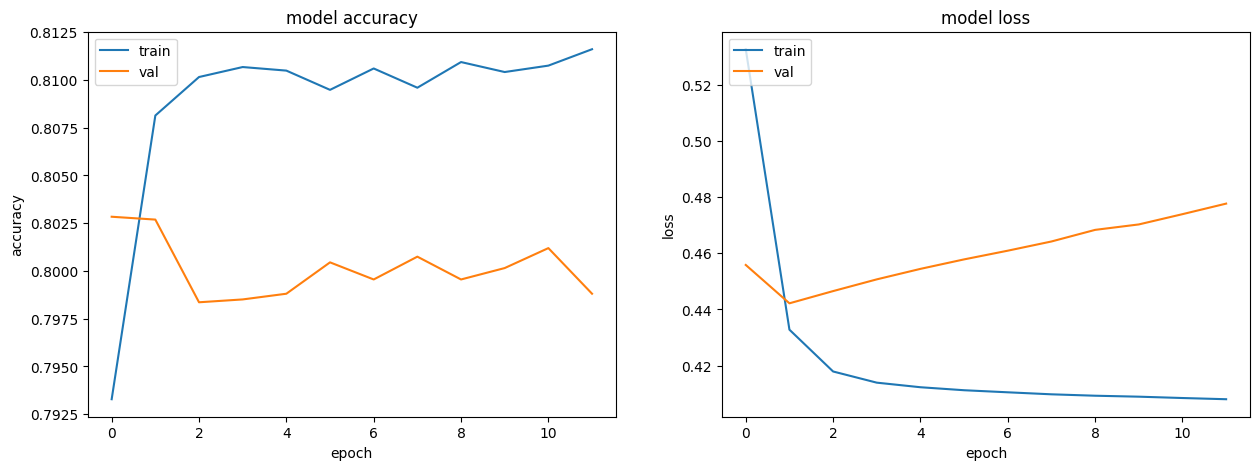

In [62]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# summarize history for accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='upper left')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper left')

plt.show()

### Evaluating our Recommender System
Now that we have trained out model, we are ready to evaluate it using the test data. In traditional Machine Learning projects, we evaluate our models using metrics such as Accuracy (for classification problems) and RMSE (for regression problems). However, such metrics are too simplistic for evaluating recommender systems.

To design a good metric for evaluating recommender systems, we need to first understand how modern recommender systems are used.

Amazon, Netflix and others uses a list of recommendations. The key here is that we don’t need the user to interact with every single item in the list of recommendations. Instead, we just need the user to interact with at least one item on the list — as long as the user does that, the recommendations have worked.

To simulate this, let’s run the following evaluation protocol to generate a list of top 10 recommended items for each user.

* For each user, randomly select 99 items that the user has not interacted with.
* Combine these 99 items with the test item (the actual item that the user last interacted with). We now have 100 items.
* Run the model on these 100 items, and rank them according to their predicted probabilities.
* Select the top 10 items from the list of 100 items. If the test item is present within the top 10 items, then we say that this is a hit.
* Repeat the process for all users. The Hit Ratio is then the average hits.

This evaluation protocol is known as **Hit Ratio @ 10**, and it is commonly used to evaluate recommender systems.


[TO DO - Students]: Fill the gaps

In [63]:
test_ratings

,userId,movieId,rating
7169,116,180,5
1809,116,271,4
4349,116,187,5
1789,305,50,5
4629,305,257,2
...,...,...,...
8883,189,607,4
500,189,526,4
2988,189,30,4
4659,189,1021,5


In [64]:
def h10ratio(test_ratings, model):
    # User-item pairs for testing
    test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

    # Dict of all items that are interacted with by each user
    user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

    all_movie_ids_set = set(all_movieIds)

    hits = []
    for (u, i) in test_user_item_set:
        interacted_items = user_interacted_items[u]
        not_interacted_items = all_movie_ids_set - set(interacted_items)
        selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
        test_items = selected_not_interacted + [i]
        predicted_labels = model.predict([np.array([u] * 100), np.array(test_items)], verbose=0).reshape(-1)
        top10_items = [test_items[i] for i in np.argsort(predicted_labels)[-10:].tolist()]

        if i in top10_items:
            hits.append(1)
        else:
            hits.append(0)
    h10r_score = sum(hits) / len(test_user_item_set)
    print(f"The Hit Ratio @ 10 is {h10r_score:.2%}")
    return h10r_score

In [65]:
h10ratio(test_ratings[:100], model)

The Hit Ratio @ 10 is 29.00%


0.29

## Your work

For the lab, we use movies reviews provided by the MovieLens 20M dataset, a popular movie ratings dataset containing 20 Million movie reviews collected from 1995 to 2015.

* Use only the 100 K first rating for training
* the 10 K following rating for validation
* the 20 K following ratin for testing (evaluation)

### Step 1 : Hyperparameters search

**[TODO - Students] using the keras-tuner module, explore the hyperparameter space to optimize the validation loss**

In [66]:
import keras_tuner

In [80]:
def TunableNFC(hp):
    # user_id embedding
    users_input = Input(shape=(1,))
    x_users = Embedding(input_dim=num_users, output_dim=hp.Choice('units', [8, 16, 32, 64, 128]))(users_input)
    x_users = Flatten()(x_users)

    # item_id embedding
    items_input = Input(shape=(1,))
    x_items = Embedding(input_dim=num_items, output_dim=hp.Choice('units', [8, 16, 32, 64, 128]))(items_input)
    x_items = Flatten()(x_items)

    # concatenation
    x = Concatenate(axis=1)([x_users, x_items])

    # output layer
    output = Dense(1, activation='sigmoid')(x)

    # Build the model
    model = Model(inputs=[users_input, items_input], outputs=output)

    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [81]:
tuner = keras_tuner.RandomSearch(TunableNFC, objective='val_loss', max_trials=5)

In [82]:
tuner.search([np.array(users), np.array(items)], np.array(labels).reshape(-1),
                    validation_split=0.2, epochs=100, verbose=1, callbacks=[es, mc])
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 00m 25s]
val_loss: 0.4428861439228058

Best val_loss So Far: 0.4424704611301422
Total elapsed time: 00h 01m 59s
INFO:tensorflow:Oracle triggered exit


In [85]:
h10ratio(test_ratings, best_model)

The Hit Ratio @ 10 is 29.21%


0.2921212121212121

**[TODO - Students] Try to find best hyper-parameters for Hit Ratio at 10**

### Step 2 : Add new features in order to improve the Hit Ratio at 10

The following code load items information and users information for Movilens 100 K dataset

In [19]:
# Load genre
genres = pd.read_csv(path + "u.genre", header=None, names=['genre', 'genreId'], sep="|")['genre'].tolist()

# Load item information
items_columns = ['movieId', 'movie title', 'release date', 'video release date', 'IMDb URL'] + genres
items = pd.read_csv(path + "u.item", header=None, names=items_columns, encoding="ISO-8859-1", sep="|")
items.head()

,movieId,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
# Add item information to ratings
ratings_with_items_info = ratings.merge(items, left_on='movieId', right_on='movieId')
ratings_with_items_info.head()

,userId,movieId,rating,timestamp,movie title,release date,video release date,IMDb URL,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,259,255,4,874724710,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,...,0,0,0,0,0,1,0,0,0,0
1,30,255,4,875059984,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,...,0,0,0,0,0,1,0,0,0,0
2,116,255,3,876452524,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,...,0,0,0,0,0,1,0,0,0,0
3,330,255,4,876544278,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,...,0,0,0,0,0,1,0,0,0,0
4,314,255,5,877886221,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,...,0,0,0,0,0,1,0,0,0,0


In [21]:
# Load occupation
occupations = pd.read_csv(path + "u.occupation", header=None, names=['occupation'], sep="|")['occupation'].tolist()

# Load user information
users = pd.read_csv(path + "u.user", header=None, names=['userId', 'age', 'gender', 'occupation', 'zip code'], sep="|")
users.head()

,userId,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [22]:
# Add item or/and user information to ratings
ratings_with_items_users_info = ratings_with_items_info.merge(users, left_on='userId', right_on='userId')
ratings_with_items_users_info.head()

,userId,movieId,rating,timestamp,movie title,release date,video release date,IMDb URL,unknown,Action,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip code
0,259,255,4,874724710,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,...,0,1,0,0,0,0,21,M,student,48823
1,259,772,4,874724882,Kids (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Kids%20(1995),0,0,...,0,0,0,0,0,0,21,M,student,48823
2,259,117,4,874724988,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,1,...,0,0,0,1,0,0,21,M,student,48823
3,259,405,3,874725120,Mission: Impossible (1996),22-May-1996,NaN,http://us.imdb.com/M/title-exact?Mission:%20Im...,0,1,...,1,0,0,0,0,0,21,M,student,48823
4,259,176,4,874725386,Aliens (1986),01-Jan-1986,NaN,http://us.imdb.com/M/title-exact?Aliens%20(1986),0,1,...,0,0,1,1,1,0,21,M,student,48823


In [23]:
''' your code here '''

' your code here '

### Step 3 - Improve the network by using a General Matrix Factorisation layer


![architecture](https://miro.medium.com/max/1400/1*3Ecg3wHR7x_AAta3JuHcUA@2x.png)

**[TODO - Students] Modify the NFC function to include an element-wise product layer instead of a concatenated & dense layer, then train and evaluate it**

### Step 4 - Final architecture


![architecture](https://miro.medium.com/max/1400/1*CoETyuU36fshduKAfFhCrg.png)

**[TODO - Students] By combining the previous question, try to reproduce the above architecture, train and evaluate it**